## <center>ТЕСТОВОЕ ЗАДАНИЕ</center>


В настоящем задании, вы получаете доступ к набору данных о стоимости недвижимости в различных районах штата Калифорния, США. 

Данные хранятся в реляционной БД в виде двух таблиц:

**neighborhoods** - случайная выборка районов штата Калифорния. Каждая строка таблицы представляет собой какой-то район, имеющий такие атрибуты, как:

    - id - уникальный идентификатор, primary key;
    - longitude - географическая долгота, град.;
    - latitude - географическая широта, град.;
    - median_house_value - медианная стоимость жилого дома в данном районе, доллар США;
    - population - численность населения района, чел.;
    - ocean_proximity - кластер по принципу близости к океану, качественная переменная;
    
**cluster_mean_values** - каждая строка данной таблицы представляет собой кластер районов, сгруппированных по принципу близости к океану. Атрибуты:
    
    - ocean_proximity_cluster - кластер по принципу близости к океану, качественная переменная;
    - mean_median_house_value - среднее значение медианной стоимости жилого дома во ВСЕХ районах данного кластера, доллар США;
    
**ОБРАТИТЕ ВНИМАНИЕ**: **mean_median_house_value** - значение для всей генеральной совокупности районов в кластере. Таблица **neighborhoods**, в свою очередь, содержит только ВЫОБРКИ из каждого кластера, но не ген. совокупности. Если вы посчитаете среднее арифметическое **median_house_value** - это будет ВЫБОРОЧНЫМ значением.
***************************************
  
  
**ВАШИ ЗАДАЧИ:**

1) Извлечь таблицу **neighborhoods** в датафрейм. В части записей отсутствуют данные в атрибуте **ocean_proximity** (null-значения), их необходимо восстановить. Фактически, это задача классификации. Проведите разведочный анализ, подумайте, как в принципе её возможно решить;
    
2) Исправить null-значения **ocean_proximity** в самой БД. Условие: нельзя заменять таблицу в БД на новую, только через обновление значений с помощью SQL;
    
3) С помощью SQL создать объединенный датасет со значениями из двух таблиц БД, т.е. чтобы у каждого района было известно среднее арифметическое медианной стоимости жилья для районов в его кластере. Условие: только с помощью SQL, не с помощью Python; 
    
4) Определить форму распределения **median_house_value** в каждом кластере. Определить выборочные средние **median_house_value** и их отклонения от средних ген. совокупностей. Все изобразить графически для каждого кластера. В виде комментария описать ваши выводы о репрезентативности выборок;
    
5) Определить зависимость стоимости жилья от численности населения района в каждом кластере. Описать в виде комментария;

P.S. Каждое задание необходимо сопроводить комментариями, в которых вы поясняете, чего конкретно добиваетесь и почему используете именно выбранный способ решения. Обоснуйте ваши действия и сформулируйте выводы.

## Задание 1
Извлечь таблицу neighborhoods в датафрейм. В части записей отсутствуют данные в атрибуте ocean_proximity (null-значения), их необходимо восстановить. Фактически, это задача классификации. Проведите разведочный анализ, подумайте, как в принципе её возможно решить

In [1]:
#загрузим необходимые для работы библиотеки
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
#Теперь загрузим датасет из файла базы данных
engine = create_engine('sqlite:///test_project.db')
sql = '''SELECT * FROM neighborhoods'''
df = pd.read_sql(sql, engine)

In [3]:
# быстрый взгляд на структуру таблицы
df.head()

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,None
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY


In [4]:
# посмотрим, какие целевые классы у нас есть
df.ocean_proximity.unique()

array([None, 'NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [5]:
# поменяем тип столбца ocean_proximity на строковый, чтобы на следующем шаге визуально посмотреть 
df['ocean_proximity'] = df['ocean_proximity'].astype(str)

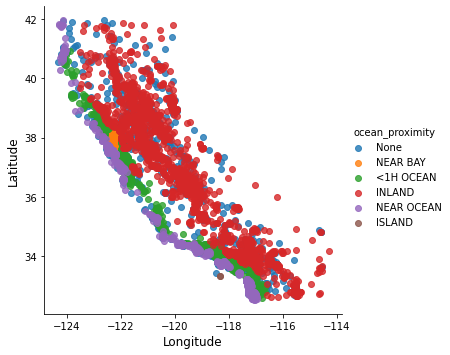

In [6]:
# Визуально оценим разброс категорий по координатам
sns.lmplot(x='longitude', y='latitude', hue='ocean_proximity', data=df, fit_reg=False)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

In [7]:
# видим, что строки с неуказанным 'ocean_proximity' разбросаны по всей карте

In [8]:
# на всякий случай глянем на количество объектов в каждом классе
df.groupby('ocean_proximity').agg({'id':'count'})

,id
ocean_proximity,
<1H OCEAN,4967
INLAND,3547
ISLAND,2
NEAR BAY,1241
NEAR OCEAN,1443
None,5013


In [9]:
# подклчючаем модули для предсказания 'ocean_proximity' методом ближайших соседей
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
# обучаем модель на части датафрейма, где целевой класс известен
X = df.query('ocean_proximity != "None"').iloc[:,1:3].values
y = df.query('ocean_proximity != "None"').iloc[:, -1].values

In [11]:
# делим таблицу на тренировочную и проверочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [12]:
# Используем метод kNN, в данном случае соседей 4. Обучаем модель
classifier = KNeighborsClassifier(n_neighbors=4)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [13]:
# предсказываем данные на тестовой выборке
y_pred = classifier.predict(X_test)

In [14]:
# ... и проверяем корректность обучения модели
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[964   3   1   4]
 [ 10 717   1   0]
 [  1   0 252   0]
 [ 12   0   3 272]]
              precision    recall  f1-score   support

   <1H OCEAN       0.98      0.99      0.98       972
      INLAND       1.00      0.98      0.99       728
    NEAR BAY       0.98      1.00      0.99       253
  NEAR OCEAN       0.99      0.95      0.97       287

    accuracy                           0.98      2240
   macro avg       0.98      0.98      0.98      2240
weighted avg       0.98      0.98      0.98      2240



Здесь мы видим, что обучение прошло более чем успешно, правильно предсказано в худшем случае 97%. Теперь применим обученную модель для поиска недостающей инфрормации

In [15]:
df_predict = df.loc[df['ocean_proximity'] == 'None']

In [16]:
X = df_predict.iloc[:,1:3].values
y = df_predict.iloc[:, -1].values

In [17]:
df_predict['ocean_proximity'] = classifier.predict(X)

/var/folders/6c/8ytfq8bs4x1_pvzrnj637pvc0000gn/T/ipykernel_47388/3177489953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['ocean_proximity'] = classifier.predict(X)


In [ ]:
# не придумал, как убрать это ошибку :(

In [18]:
# объединяем имевшиеся данные с вновь предсказанными
df_predict = df_predict.merge(df.query('ocean_proximity != "None"'), how = 'outer')

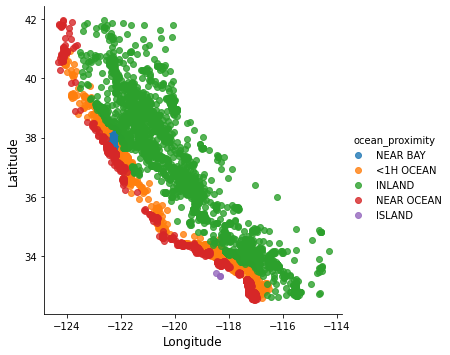

In [19]:
# визуально оцениваем качество полученных данных
sns.lmplot(x='longitude', y='latitude', hue='ocean_proximity', data=df_predict, fit_reg=False)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

В целом картина нравится, даже остров предсказан как остров. Есть сомнения по группе '<1H OCEAN', упирающихся прямов океан - то ли там непроходимые скалы, то ли расчеты могли быть и поточнее.

upd. Осмотр спутниковых карт показал, что там не скалы, а целый заповедник 'Point Reyes National Seashore' и ехать до ближайшего океана действительно долго.

# Задание 2
Исправить null-значения ocean_proximity в самой БД. Условие: нельзя заменять таблицу в БД на новую, только через обновление значений с помощью SQL

In [20]:
# перезаписываем наши данные обратно в базу данных:
df_predict.to_sql('neighborhoods', con=engine, if_exists='replace', index = False)

16213

Размеры датафреймов до записи и после записи равны: True


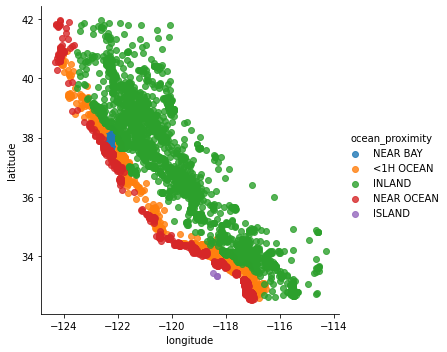

In [21]:
# проверим, что мы не накосячили при записи данных, сравним размеры датафрейма и еще раз выведем карту
print('Размеры датафреймов до записи и после записи равны:', df.size == (pd.read_sql(sql, engine)).size)
sns.lmplot(x='longitude', y='latitude', hue='ocean_proximity', data=pd.read_sql(sql, engine), fit_reg=False)

Белиссимо!

## Задание 3
С помощью SQL создать объединенный датасет со значениями из двух таблиц БД, т.е. чтобы у каждого района было известно среднее арифметическое медианной стоимости жилья для районов в его кластере. Условие: только с помощью SQL, не с помощью Python

In [22]:
# За что вы так Python, отличный язык! Ну ладно...

sql3 = '''
    SELECT id, longitude, latitude, median_house_value, population, ocean_proximity, mean_median_house_value
    FROM neighborhoods 
    LEFT JOIN cluster_mean_values ON ocean_proximity = ocean_proximity_cluster
'''

df3 = pd.read_sql(sql3, engine)

In [23]:
# проверяем, что всё сджоинилось успешно
df3.head()

,id,longitude,latitude,median_house_value,population,ocean_proximity,mean_median_house_value
0,0,-122.23,37.88,452600.0,322.0,NEAR BAY,259212.31
1,3,-122.25,37.85,341300.0,558.0,NEAR BAY,259212.31
2,6,-122.25,37.84,299200.0,1094.0,NEAR BAY,259212.31
3,7,-122.25,37.84,241400.0,1157.0,NEAR BAY,259212.31
4,9,-122.25,37.84,261100.0,1551.0,NEAR BAY,259212.31


In [24]:
# выведем уникальные значения для каждой категории, чтобы исключить ошибки
print(df3.groupby('ocean_proximity').agg({'mean_median_house_value':'unique'}))

                mean_median_house_value
ocean_proximity                        
<1H OCEAN                   [240084.29]
INLAND                      [124805.39]
ISLAND                       [380440.0]
NEAR BAY                    [259212.31]
NEAR OCEAN                  [249433.98]


Перфекто!

## Задание 4
Определить форму распределения median_house_value в каждом кластере. Определить выборочные средние median_house_value и их отклонения от средних ген. совокупностей. Все изобразить графически для каждого кластера. В виде комментария описать ваши выводы о репрезентативности выборок

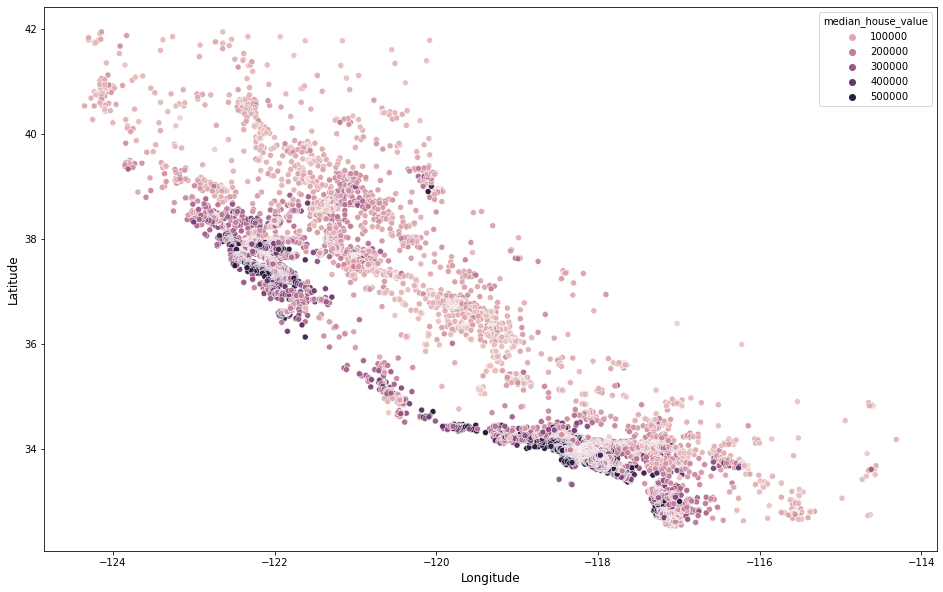

In [25]:
# Ради интереса взглянем, как стоимость жилья зависит от местоположения
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df3, x="longitude", y="latitude", hue="median_house_value", legend='brief')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

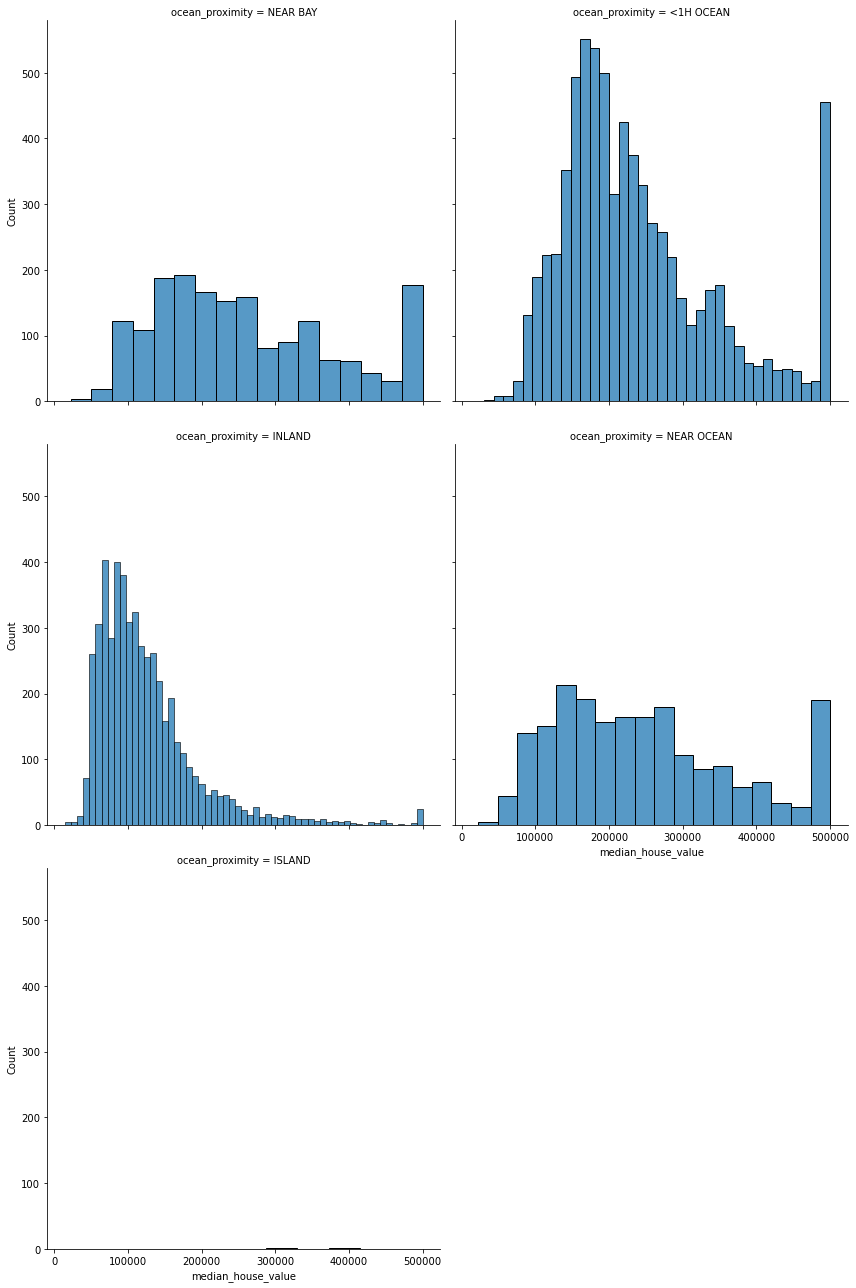

In [26]:
g = sns.FacetGrid(data=df3, col='ocean_proximity', col_wrap=2, height=6, aspect= 1)
g.map(sns.histplot, 'median_house_value')

В целом видим нормальное распределение по всем кластерам. Также видим выбросы в виде очень дорогой недвижимости - это может быть как ошибка данных, так и действительно видовые дома, разбросанные вдоль океана и в часе езды от него. Также у нас еле заметен график наших трех домов на островах, но он есть!

<Figure size 1152x720 with 0 Axes>

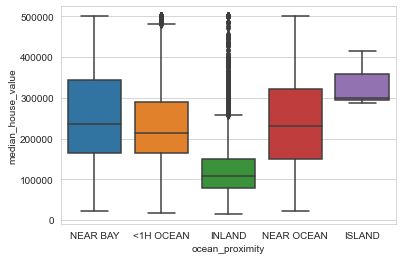

<Figure size 1152x720 with 0 Axes>

In [31]:
# посмотрим на разброс значений в боксплотах:
sns.set_style("whitegrid")
sns.boxplot(data=df3, y='median_house_value', x='ocean_proximity')
plt.figure(figsize=(16, 10))

In [32]:
# к сожалению мне не удалось победить график и добавить туда медианы из ГС
# поэтому выведу их отдельно для ручной проверки
df4 = df3.groupby('ocean_proximity', as_index=False)\
    .agg({'median_house_value':'median', 'mean_median_house_value':'median'})\
    .rename(columns={'ocean_proximity':'Кластер',
                     'median_house_value':'Среднее подвыборки',
                     'mean_median_house_value':'Среднее ГС'})
df4['Ст. отклонение'] = df3.groupby('ocean_proximity', as_index=False)['median_house_value'].std().round(2).median_house_value
df4

,Кластер,Среднее подвыборки,Среднее ГС,Ст. отклонение
0,<1H OCEAN,214650.0,240084.29,106594.16
1,INLAND,109200.0,124805.39,70588.03
2,ISLAND,300000.0,380440.00,70109.65
3,NEAR BAY,235600.0,259212.31,121966.83
4,NEAR OCEAN,231300.0,249433.98,122377.23


In [33]:
#Ручная проверка показывает, что выборочное среднее находится достаточно близко к среднему ГС.

## Задание 5
Определить зависимость стоимости жилья от численности населения района в каждом кластере. Описать в виде комментария

Здесь мы построим графики корелляции между средней стоимостью жилья и населением поочередно для каждого кластера. Также добавим на графики прямую для наглядности. Если прямая пойдет под наклоном и наблюдения будут стремиться к ней, то мы подтвердим корреляцию между переменными.

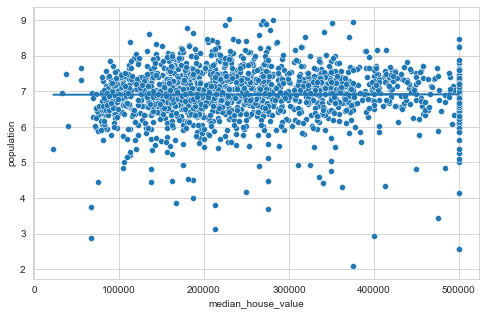

In [34]:
x = df3.query('ocean_proximity == "NEAR BAY"')["median_house_value"]
y = df3.query('ocean_proximity == "NEAR BAY"')["population"].apply(np.log)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x, y=y)
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b)

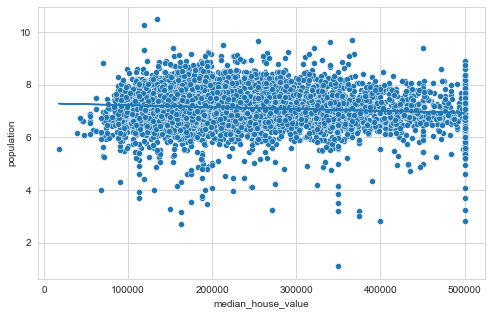

In [35]:
x = df3.query('ocean_proximity == "<1H OCEAN"')["median_house_value"]
y = df3.query('ocean_proximity == "<1H OCEAN"')["population"].apply(np.log)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x, y=y)
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b)

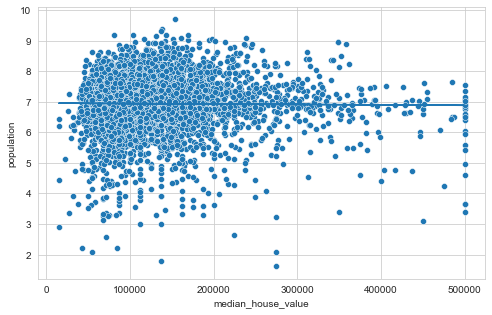

In [36]:
x = df3.query('ocean_proximity == "INLAND"')["median_house_value"]
y = df3.query('ocean_proximity == "INLAND"')["population"].apply(np.log)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x, y=y)
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b)

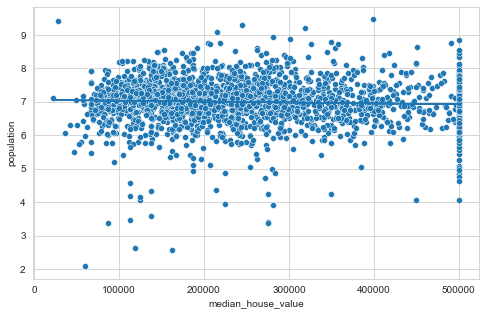

In [37]:
x = df3.query('ocean_proximity == "NEAR OCEAN"')["median_house_value"]
y = df3.query('ocean_proximity == "NEAR OCEAN"')["population"].apply(np.log)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x, y=y)
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b)

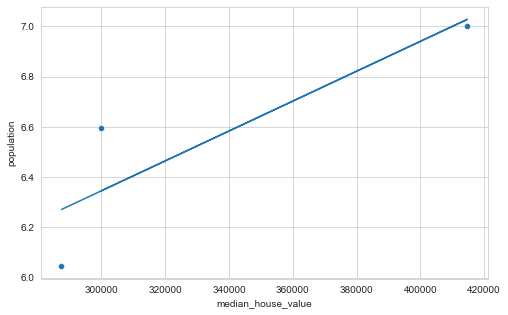

In [38]:
x = df3.query('ocean_proximity == "ISLAND"')["median_house_value"]
y = df3.query('ocean_proximity == "ISLAND"')["population"].apply(np.log)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x, y=y)
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b)

Выводы, которые можно сделать исходя из графиков: зависимость между средней стоимостью жилья и населением не наблюдается или очень слабо выражена. Единственный график у нас пошел вверх в кластере острова, но там у нас всего три наблюдения и вывод о наличии корреляции на основе столь малочисленных данных сделать к сожалению нельзя.

In [39]:
#хорошего дня! :)